/Users/vpro/opt/anaconda3/envs/Torch_Info_theory/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vpro/opt/anaconda3/envs/Torch_Info_theory/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training with target multiplier: 0.1
Epoch 1, Train Loss: 1.6288, Train Accuracy: 42.30%, Test Accuracy: 39.83%
Epoch 2, Train Loss: 1.1353, Train Accuracy: 57.17%, Test Accuracy: 50.85%
Epoch 3, Train Loss: 1.0083, Train Accuracy: 59.76%, Test Accuracy: 51.69%
Epoch 4, Train Loss: 0.9378, Train Accuracy: 63.42%, Test Accuracy: 48.31%
Epoch 5, Train Loss: 0.8264, Train Accuracy: 67.44%, Test Accuracy: 51.69%

Training with target multiplier: 0.2
Epoch 1, Train Loss: 1.8117, Train Accuracy: 64.31%, Test Accuracy: 55.08%
Epoch 2, Train Loss: 1.6241, Train Accuracy: 68.47%, Test Accuracy: 50.00%
Epoch 3, Train Loss: 1.5536, Train Accuracy: 68.96%, Test Accuracy: 50.85%
Epoch 4, Train Loss: 1.3961, Train Accuracy: 70.43%, Test Accuracy: 51.69%
Epoch 5, Train Loss: 1.2452, Train Accuracy: 72.44%, Test Accuracy: 60.17%

Training with target multiplier: 0.3
Epoch 1, Train Loss: 2.0547, Train Accuracy: 69.81%, Test Accuracy: 52.54%
Epoch 2, Train Loss: 1.7688, Train Accuracy: 72.76%, Test Acc

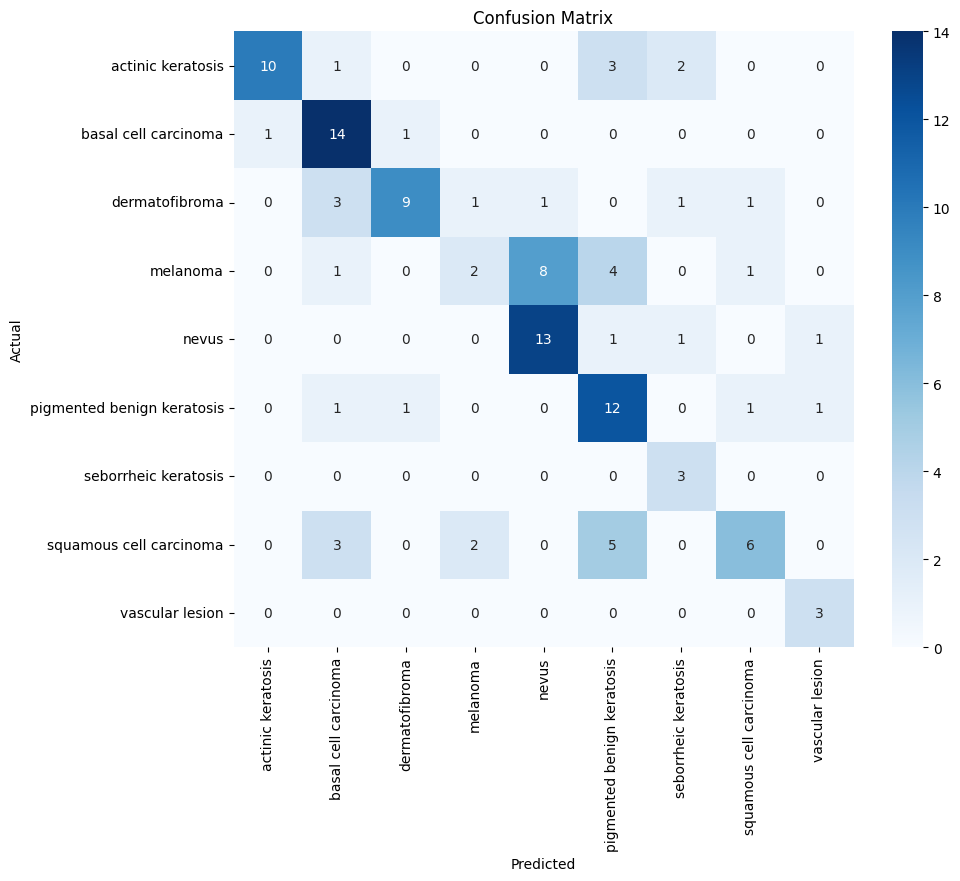

Overall Accuracy: 0.61
Accuracy for actinic keratosis: 0.62
Accuracy for basal cell carcinoma: 0.88
Accuracy for dermatofibroma: 0.56
Accuracy for melanoma: 0.12
Accuracy for nevus: 0.81
Accuracy for pigmented benign keratosis: 0.75
Accuracy for seborrheic keratosis: 1.00
Accuracy for squamous cell carcinoma: 0.38
Accuracy for vascular lesion: 1.00


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def load_data():
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    train_dataset = ImageFolder('../data/Skin_cancer_ISIC/Train', transform=transform)
    test_dataset = ImageFolder('../data/Skin_cancer_ISIC/Test', transform=transform)
    
    # Calcul des poids pour le sur-échantillonnage
    class_counts = Counter(train_dataset.targets)
    total_samples = sum(class_counts.values())
    class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
    sample_weights = [class_weights[cls] for cls in train_dataset.targets]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
    
    # Calcul des poids des classes pour la fonction de perte
    class_weights = torch.tensor([class_weights[i] for i in range(len(class_counts))], dtype=torch.float)
    
    return train_loader, test_loader, len(train_dataset.classes), class_weights

def initialize_model(num_classes):
    model = models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    for param in model.layer4.parameters():
        param.requires_grad = True
    return model

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    return accuracy, all_preds, all_labels

def train_model(model, train_loader, test_loader, class_weights, num_epochs=50, use_early_stopping=False):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = model.to(device)
    class_weights = class_weights.to(device)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    
    epsilon = 1e-4
    target_multipliers = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    epochs_per_multiplier = num_epochs // len(target_multipliers)

    best_accuracy = 0
    patience = 5
    counter = 0

    for t in target_multipliers:
        print(f"\nTraining with target multiplier: {t}")
        for epoch in range(epochs_per_multiplier):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            use_early_stopping = False
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                
                progressive_target = torch.zeros(labels.size(0), model.fc.out_features, device=device)
                progressive_target.scatter_(1, labels.unsqueeze(1), t)
                
                loss = criterion(outputs, progressive_target)
                
                if loss.item() > epsilon:
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                pred = outputs.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels.view_as(pred)).sum().item()
                total += labels.size(0)
            
            train_loss = running_loss / len(train_loader)
            train_accuracy = 100. * correct / total

            test_accuracy, _, _ = evaluate_model(model, test_loader, device)
            
            print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
                  f'Test Accuracy: {test_accuracy:.2f}%')

            if use_early_stopping:
                if test_accuracy > best_accuracy:
                    best_accuracy = test_accuracy
                    counter = 0
                    torch.save(model.state_dict(), 'best_model.pth')
                else:
                    counter += 1
                    if counter >= patience:
                        print(f"Early stopping triggered. Best accuracy: {best_accuracy:.2f}%")
                        model.load_state_dict(torch.load('best_model.pth'))
                        return model

    return model

def analyze_errors(model, test_loader, class_names):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    print(f"Overall Accuracy: {accuracy:.2f}")

    for i, class_name in enumerate(class_names):
        class_accuracy = cm[i, i] / cm[i].sum()
        print(f"Accuracy for {class_name}: {class_accuracy:.2f}")

def main():
    train_loader, test_loader, num_classes, class_weights = load_data()
    model = initialize_model(num_classes)
    trained_model = train_model(model, train_loader, test_loader, class_weights, use_early_stopping=False)
    
    # Analyse des erreurs
    class_names = train_loader.dataset.classes
    analyze_errors(trained_model, test_loader, class_names)

if __name__ == '__main__':
    main()
    